In [1]:
#new
from keras.layers import BatchNormalization
from keras import regularizers
##
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime
import cv2
import os
import io

In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Define class labels
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Initialize arrays to hold the images and labels
x_train = []  # Training images
y_train = []  # Training labels
x_test = []   # Testing images
y_test = []   # Testing labels

# Image size
image_size = 128

# Loop over each label to load cleaned training images
for label in labels:
    # Define the path for the current class's cleaned training images
    trainPath = os.path.join("C:\\Users\\ASUS\\Download\\Mridata\\Data\\Brain_Tumor\\Cleaned_Training", label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file), 0)  # Load the image in grayscale
        image = cv2.bilateralFilter(image, 2, 50, 50)  # Remove noise from the image
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)  # Apply pseudocolor to the image
        image = cv2.resize(image, (image_size, image_size))  # Resize the image
        x_train.append(image)
        y_train.append(labels.index(label))  # The label corresponds to the index of the class

# Loop over each label to load cleaned testing images
for label in labels:
    # Define the path for the current class's cleaned testing images
    testPath = os.path.join("C:\\Users\\ASUS\\Download\\Mridata\\Data\\Brain_Tumor\\Cleaned_Training", label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file), 0)  # Load the image in grayscale
        image = cv2.bilateralFilter(image, 2, 50, 50)  # Remove noise
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)  # Apply pseudocolor
        image = cv2.resize(image, (image_size, image_size))  # Resize the image
        x_test.append(image)
        y_test.append(labels.index(label))  # The label corresponds to the index of the class

# Convert the lists to numpy arrays and normalize the images (values between 0 and 1)
x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0

# Print the shape of the dataset to verify
print(x_train.shape)
print(x_test.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 278.88it/s]


(5712, 128, 128, 3)
(1311, 128, 128, 3)


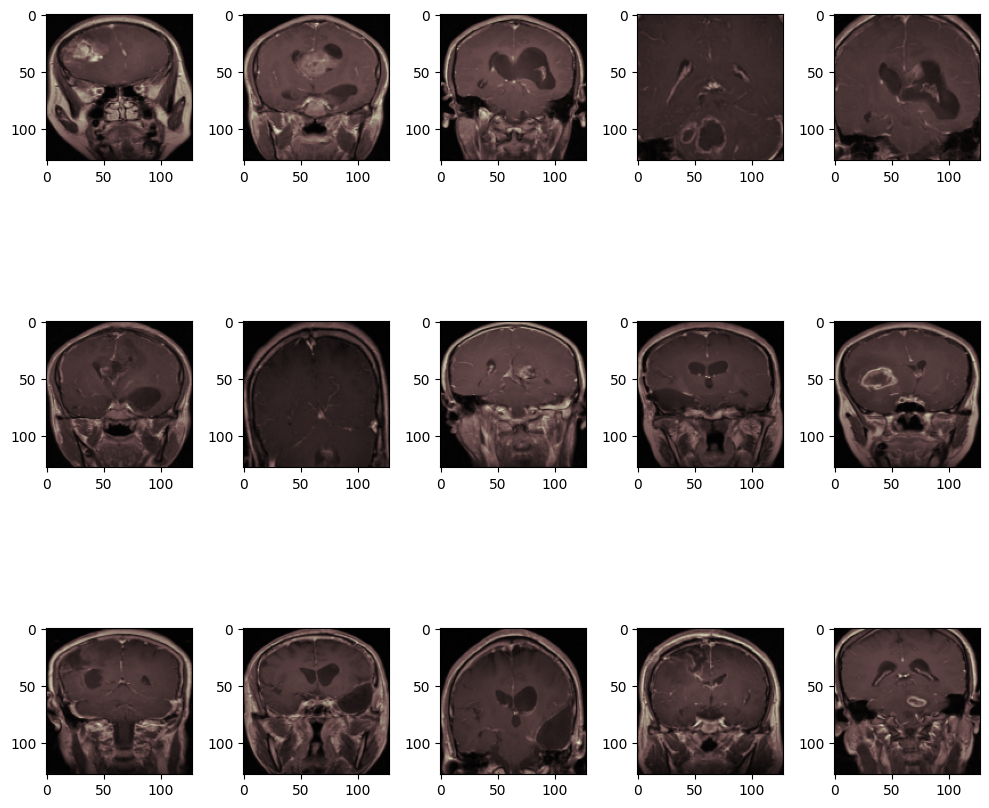

In [3]:

images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [4]:
x_train, y_train = shuffle(x_train,y_train, random_state=42) 

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(1143, 128, 128, 3)


In [5]:

# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

In [6]:
# Define the confusion matrix logging function
def log_confusion_matrix(epoch, logs):
    # Use the validation data to predict and calculate the confusion matrix
    val_preds = np.argmax(model.predict(x_val), axis=1)
    val_true = np.argmax(y_val, axis=1)

    # Calculate confusion matrix
    cm = confusion_matrix(val_true, val_preds)

    # Plot confusion matrix
    figure = plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - Epoch {epoch+1}")
    plt.colorbar()
    tick_marks = np.arange(len(cm))
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Convert plot to image and log it
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    # Write to TensorBoard
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", image, step=epoch)
    plt.close(figure)

In [7]:
net = ResNet50(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(image_size,image_size,3))
#for layer in net.layers[-10:]:
 #   layer.trainable = True

In [8]:

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.3)(model)
model = BatchNormalization()(model) 
#
model = Dense(256, activation='relu', 
              kernel_regularizer=regularizers.l2(0.01))(model)
model = Dropout(0.3)(model)  # Extra dropout after Dense layer
#
model = Dense(4, activation="softmax", 
              kernel_regularizer=regularizers.l2(0.01))(model)
##
model = Model(inputs= net.input, outputs= model)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

In [9]:
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard


In [10]:

#create a writer variable for writing into the log folder.
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
file_writer_cm = tf.summary.create_file_writer(logdir)

#tensorboard = TensorBoard(logdir, histogram_freq=1)
#log_dir=logdir, histogram_freq=1, write_graph=True, write_images=True
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=1,write_graph=True, write_images=True)
#Changed - this to above -tensorboard = TensorBoard(log_dir=logdir, histogram_freq=1)

BATCH_SIZE = 64
EPOCHS = 50

Checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.keras',monitor = 'val_loss', verbose = 1, save_best_only = True,save_weights_only=False,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min',min_lr=1e-6)
####
from tensorflow.keras.callbacks import LearningRateScheduler
import math

def cyclic_lr(epoch):
    base_lr = 1e-5
    max_lr = 1e-4
    step_size = 10
    cycle = math.floor(1 + epoch / (2 * step_size))
    x = abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

LR_Scheduler = LearningRateScheduler(cyclic_lr)
### and on below line added LR_Schedular
callbacks = [ES,RL,tensorboard,Checkpoint, LR_Scheduler,LambdaCallback(on_epoch_end=log_confusion_matrix)]

history_res = model.fit(datagen.flow(x_train, y_train, batch_size=20),validation_data = (x_val,y_val),epochs = EPOCHS,callbacks = callbacks)


Epoch 1/50
229/229 [==============================] - ETA: 0s - loss: 5.8228 - accuracy: 0.5537
Epoch 1: val_loss improved from inf to 19.30544, saving model to model-01-0.28-19.31.keras
229/229 [==============================] - 57s 173ms/step - loss: 5.8228 - accuracy: 0.5537 - val_loss: 19.3054 - val_accuracy: 0.2765 - lr: 1.0000e-05
Epoch 2/50
229/229 [==============================] - ETA: 0s - loss: 5.1091 - accuracy: 0.7875
Epoch 2: val_loss did not improve from 19.30544
229/229 [==============================] - 32s 138ms/step - loss: 5.1091 - accuracy: 0.7875 - val_loss: 20.0400 - val_accuracy: 0.1995 - lr: 1.9000e-05
Epoch 3/50
229/229 [==============================] - ETA: 0s - loss: 4.7641 - accuracy: 0.8722
Epoch 3: val_loss improved from 19.30544 to 7.06274, saving model to model-03-0.26-7.06.keras
229/229 [==============================] - 33s 142ms/step - loss: 4.7641 - accuracy: 0.8722 - val_loss: 7.0627 - val_accuracy: 0.2607 - lr: 2.8000e-05
Epoch 4/50
229/229 [====

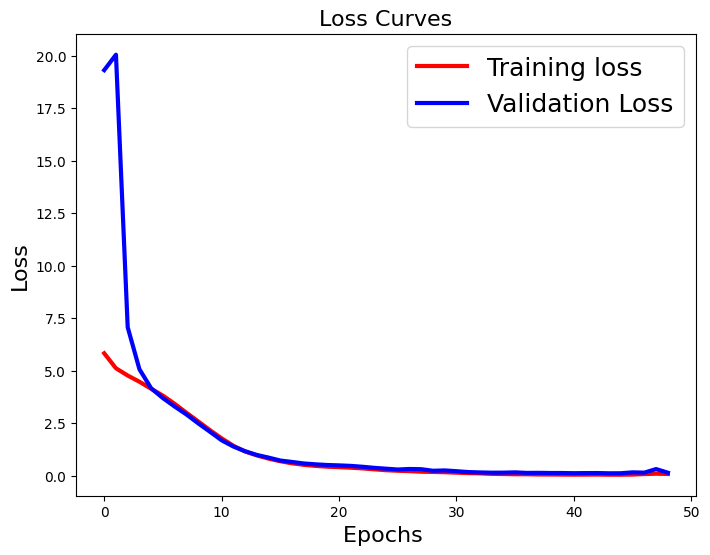

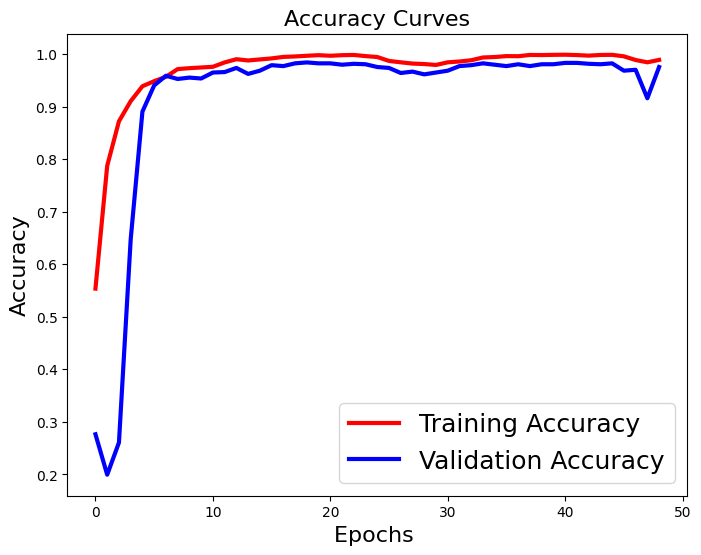

In [13]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_res.history['loss'],'r',linewidth=3.0)
plt.plot(history_res.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_res.history['accuracy'],'r',linewidth=3.0)
plt.plot(history_res.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

41/41 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       300
           1       0.99      0.97      0.98       306
           2       0.99      0.99      0.99       405
           3       0.98      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



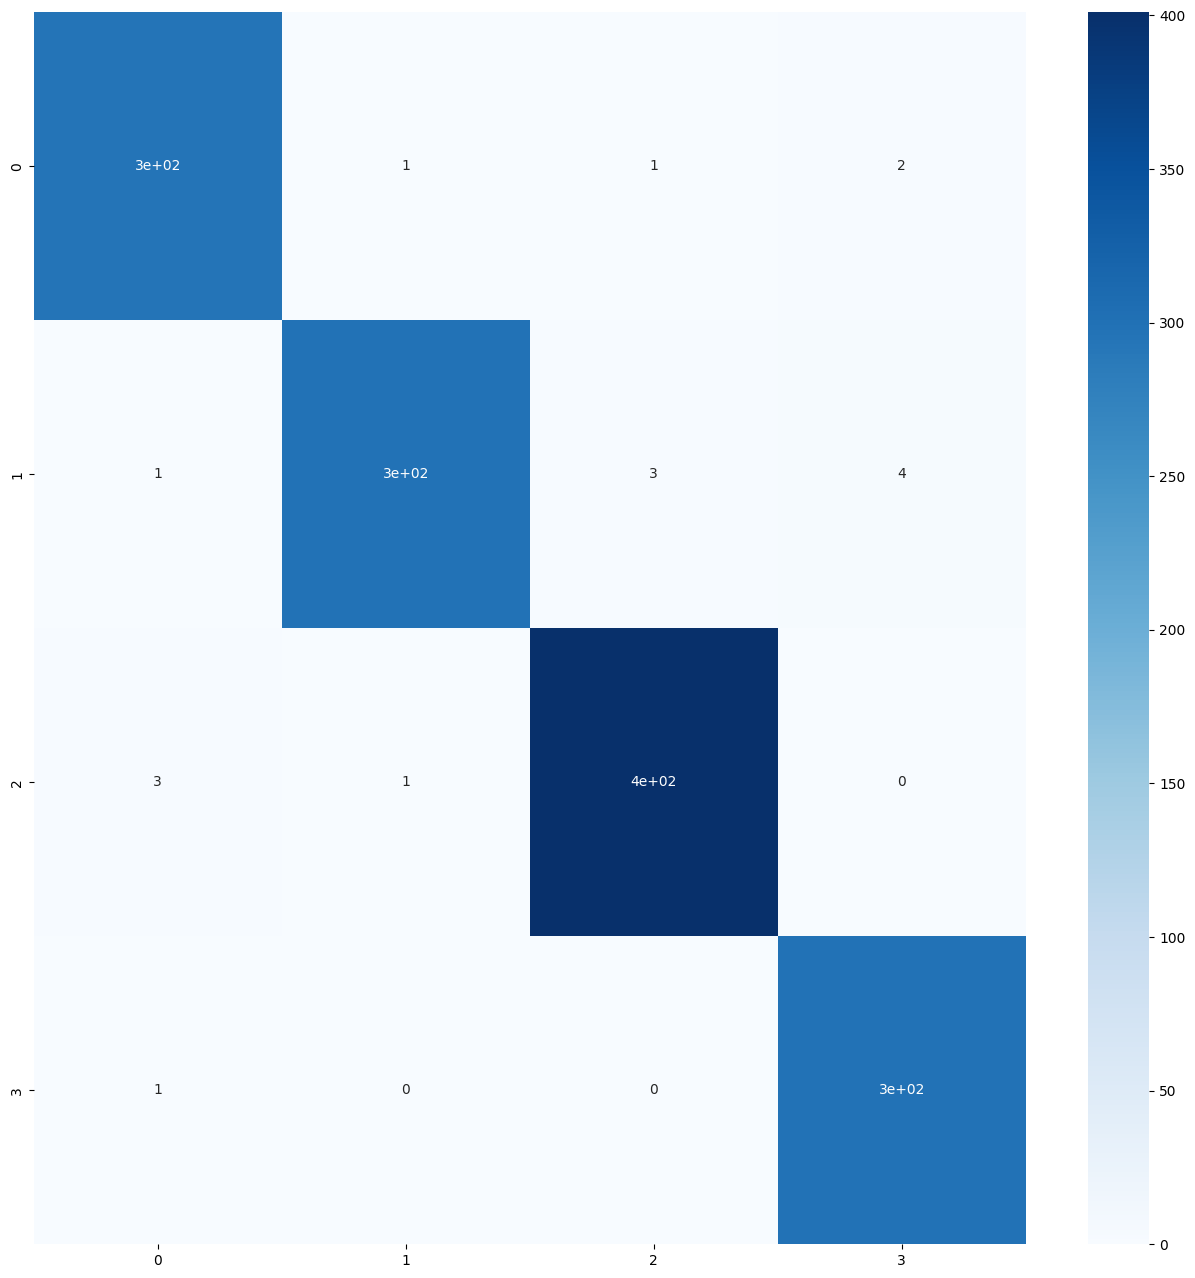

In [14]:
predicted_classes = np.argmax(model.predict(x_test), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

In [15]:
loss,acc = model.evaluate(x_test,y_test)

41/41 [==============================] - 1s 24ms/step - loss: 0.0826 - accuracy: 0.9870


In [16]:
model.save('resnet_final.h5')

In [ ]:
# # Unfreeze some layers of the base ResNet50 model
# for layer in net.layers[-20:]:  # Unfreeze the last 20 layers
#     if not isinstance(layer, tf.keras.layers.BatchNormalization):  # Exclude BatchNorm layers
#         layer.trainable = True
#         print(f"Layer {layer.name} - Trainable: {layer.trainable}")
# # Recompile the model with a lower learning rate for fine-tuning
# adam_finetune = tf.keras.optimizers.Adam(learning_rate=1e-5)  # Smaller learning rate
# model.compile(optimizer=adam_finetune, loss='categorical_crossentropy', metrics=['accuracy'])

# before_weights = [layer.get_weights() for layer in model.layers[-20:]]
# # Fine-tune the model with unfrozen layers
# history_finetune = model.fit(datagen.flow(x_train, y_train, batch_size=20),
#                              validation_data=(x_val, y_val),
#                              epochs=40,  # Fine-tune for fewer epochs
#                              callbacks=callbacks)
# after_weights = [layer.get_weights() for layer in model.layers[-20:]]

In [ ]:
# print("Before weights:", before_weights)
# print("After weights:", after_weights)

In [ ]:
# # Save the fine-tuned model
# model.save('model_finetuned.h5')

# # Reload the fine-tuned model
# model_finetuned = tf.keras.models.load_model('model_finetuned.h5')
# model_finetuned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Evaluate the fine-tuned model on test data
# loss, acc = model_finetuned.evaluate(x_test, y_test)
# print(f"Test Loss: {loss}")
# print(f"Test Accuracy: {acc}")


In [ ]:
# Test Data Generator: Only Rescaling (No Augmentation)
#test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Load Test Data into the Generator
#test_generator = test_datagen.flow(
#    x_test,               # Your test images
#    y_test,               # Your test labels
#    batch_size=32,        # Batch size for evaluation
#    shuffle=False         # Do not shuffle for test evaluation
#)


In [ ]:
#test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

#print(f"Test Loss: {test_loss:.4f}")
#print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
#predicted_classes = np.argmax(model.predict(x_test), axis = 1)
#confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
#plt.figure(figsize = (16, 16))
#sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
#print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

In [ ]:
# loss,acc = model.evaluate(x_test,y_test)

In [ ]:
# for i, layer in enumerate(model.layers):
#     print(f"Layer {i}: {layer.name} - Trainable: {layer.trainable}")

In [ ]:
# # Evaluate the fine-tuned model
# loss_finetuned, acc_finetuned = model.evaluate(x_test, y_test)
# print(f"Fine-tuned Test Accuracy: {acc_finetuned}")

# # Reload the original model and evaluate again
# original_model = tf.keras.models.load_model('model_finetuned.h5')
# loss_original, acc_original = original_model.evaluate(x_test, y_test)
# print(f"Original Model Test Accuracy: {acc_original}")
